# Reading-in and Downloading ALS Vendor DEM Products

* coincident.io.xarray
    * load_usgs_dem
    * load_neon_dem
    * load_ncalm_dem
    * load_noaa_dem

* coincident.io.download
    * download_usgs_dem
    * download_neon_dem
    * download_noaa_dem
    * download_ncalm_dem

> [!IMPORTANT]  
> Note that some download functions download the individual tiles while others download a mosaic'd version

> [!NOTE]  
> Coincident does not support the downloading / processing of lidar point cloud products due to the required PDAL dependency. That being said download_neon_dem() allows for the downloading of LPC tiles (.laz) as PDAL is not necessary there

In [ ]:
import coincident
import geopandas as gpd
from shapely.geometry import box
import xarray as xr

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Example with 3DEP & NEON overlap

In [3]:
workunit = "CO_CentralEasternPlains_1_2020"
df_wesm = coincident.search.wesm.read_wesm_csv()
gf_usgs = coincident.search.wesm.load_by_fid(
    df_wesm[df_wesm.workunit == workunit].index
)

gf_usgs

,workunit,workunit_id,project,project_id,start_datetime,end_datetime,ql,spec,p_method,dem_gsd_meters,...,seamless_category,seamless_reason,lpc_link,sourcedem_link,metadata_link,geometry,collection,datetime,dayofyear,duration
0,CO_CentralEasternPlains_1_2020,192973,CO_CentralEasternPlains_2020_D20,192976,2020-05-09,2020-06-10,QL 2,USGS Lidar Base Specification 2.1,linear-mode lidar,1.0,...,Meets,Meets 3DEP seamless DEM requirements,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,"MULTIPOLYGON (((-103.7138 39.8835, -103.7138 3...",3DEP,2020-05-25,146,32


In [4]:
# We will examine the 'sourcedem' 1m
# NOTE: it's important to note the *vertical* CRS of the data
gf_usgs.iloc[0]

workunit                                 CO_CentralEasternPlains_1_2020
workunit_id                                                      192973
project                                CO_CentralEasternPlains_2020_D20
project_id                                                       192976
start_datetime                                      2020-05-09 00:00:00
end_datetime                                        2020-06-10 00:00:00
ql                                                                 QL 2
spec                                  USGS Lidar Base Specification 2.1
p_method                                              linear-mode lidar
dem_gsd_meters                                                      1.0
horiz_crs                                                          6342
vert_crs                                                           5703
geoid                                                           GEOID18
lpc_pub_date                                        2020-12-11 0

In [5]:
gf_neon = coincident.search.search(dataset="neon", intersects=gf_usgs, datetime=["2020"])

/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [6]:
m = gf_usgs.explore(color='black')
gf_neon.explore(m=m, column="id", popups=True)

We will evaluate small subset to showcase spatial filtering and clipping. Also for speed for deomstration purposes.

Let's subset based on some contextual LULC data

In [7]:
gf_wc = coincident.search.search(
    dataset="worldcover",
    intersects=gf_neon,
    datetime=["2020"],
) 

In [8]:
# Same with LandCover
dswc = coincident.io.xarray.to_dataset(
    gf_wc,
    bands=["map"],
    aoi=gf_neon,
    mask=True,
    resolution=0.00027, #~30m
)
dswc = dswc.rename(map="landcover")
dswc = dswc.compute()

In [ ]:
# arbitrary bbox that will be our subset area (all cropland)
bbox_geometry = box(-102.505, 39.675, -102.49, 39.685)
aoi = gpd.GeoDataFrame(
    geometry=[bbox_geometry],
    crs="EPSG:4326"
)

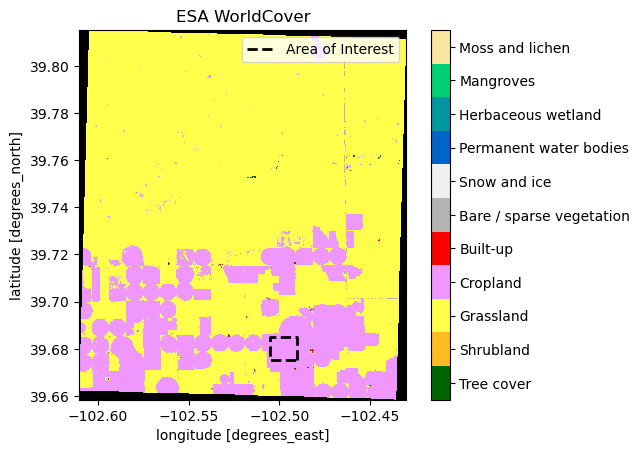

In [10]:
ax = coincident.plot.plot_esa_worldcover(dswc)
aoi.plot(ax=ax, 
         facecolor='none',
         edgecolor='black',
         linestyle="--",
         linewidth=2)
from matplotlib.lines import Line2D
custom_line = Line2D([0], [0], color='black', linestyle='--', lw=2)
ax.legend([custom_line], ['Area of Interest'], loc='upper right', fontsize=10)
ax.set_title("ESA WorldCover");

Actually read-in and download the DEMs

In [11]:
coincident.io.xarray.load_neon_dem?

Signature:
coincident.io.xarray.load_neon_dem(
    aoi: 'gpd.GeoDataFrame',
    datetime_str: 'str',
    site_id: 'str',
    product: 'str',
    res: 'int' = 1,
    clip: 'bool' = True,
) -> 'xr.DataArray'
Docstring:
Load and merge NEON LiDAR tiles (DSM, DTM, or CHM) based on an AOI by querying the NEON API.

Steps:
    1. Convert the datetime string to a month string in the format YYYY-MM.
    2. Determine appropriate UTM CRS for the AOI.
    3. Query the NEON API using a preset product code.
    4. Filter the returned files based on product type and spatial intersection.
    5. Load and optionally coarsen each GeoTIFF tile.
    6. Merge the tiles and optionally clip the mosaic to the AOI.

Parameters:
    aoi (gpd.GeoDataFrame): Area of interest geometry to query against
    datetime_str (str): Date string in YYYY-MM-DD format
    site_id (str): NEON site identifier
    product (str): Product type to load ('dsm', 'dtm', or 'chm')
    res (int): Resolution factor to coarsen DEM by (de

In [12]:
datetime_str = gf_neon.end_datetime.item().strftime('%Y-%m-%d')
site_id = gf_neon.id.item()
datetime_str, site_id

('2020-06-10', 'ARIK')

In [13]:
%%time
da_neon_dem = coincident.io.xarray.load_neon_dem(aoi,
                                          datetime_str=datetime_str,
                                          site_id=site_id,
                                          product="dsm")

/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
  if riods.subdatasets:
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
  if riods.subdatasets:
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
  if riods.subdatasets:
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
  if riods.subdatasets:
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: 

CPU times: user 341 ms, sys: 26.7 ms, total: 368 ms
Wall time: 4.57 s


/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rioxarray/_io.py:1146: RuntimeWarning: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
  if riods.subdatasets:


In [14]:
da_neon_dem

<xarray.DataArray 'elevation' (y: 1146, x: 1318)> Size: 6MB
dask.array<getitem, shape=(1146, 1318), dtype=float32, chunksize=(166, 1000), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 11kB 7.14e+05 7.14e+05 ... 7.153e+05 7.153e+05
  * y            (y) float64 9kB 4.395e+06 4.395e+06 ... 4.396e+06 4.396e+06
    spatial_ref  int64 8B 0

In [21]:
#dims, hillshade_data = coincident.plot.hillshade(da_neon_dem)
#da_neon_hillshade = xr.DataArray(
#    data=hillshade_data,
#    dims=dims,
#    coords={dim: da_neon_dem[dim] for dim in dims},
#)

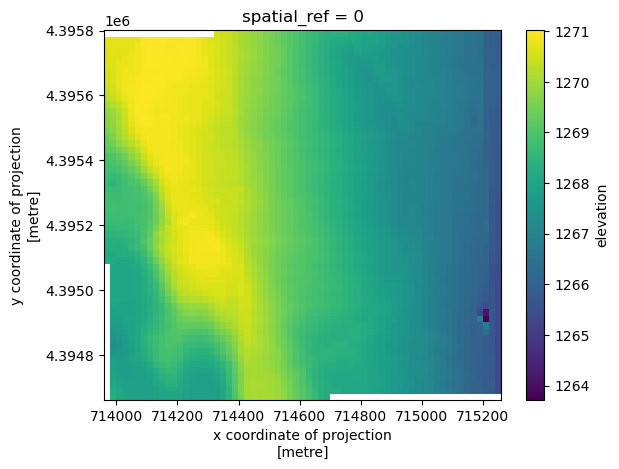

In [22]:
#da_neon_hillshade.coarsen(x=20, y=20, boundary='trim').mean().plot.imshow(cmap='Grays',
#                                                                          add_colorbar=False)
da_neon_dem.coarsen(x=20, y=20, boundary='trim').mean().plot.imshow();

In [23]:
usgs_project = gf_usgs['project'].item()
usgs_project

'CO_CentralEasternPlains_2020_D20'

In [26]:
%%time
da_usgs_dem = coincident.io.xarray.load_usgs_dem(aoi, usgs_project)

CPU times: user 1.28 s, sys: 1.04 s, total: 2.33 s
Wall time: 2.63 s


In [27]:
da_usgs_dem

<xarray.DataArray 'elevation' (y: 1146, x: 1317)> Size: 6MB
dask.array<getitem, shape=(1146, 1317), dtype=float32, chunksize=(1146, 1317), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 11kB 7.14e+05 7.14e+05 ... 7.153e+05 7.153e+05
  * y            (y) float64 9kB 4.396e+06 4.396e+06 ... 4.395e+06 4.395e+06
    spatial_ref  int64 8B 0

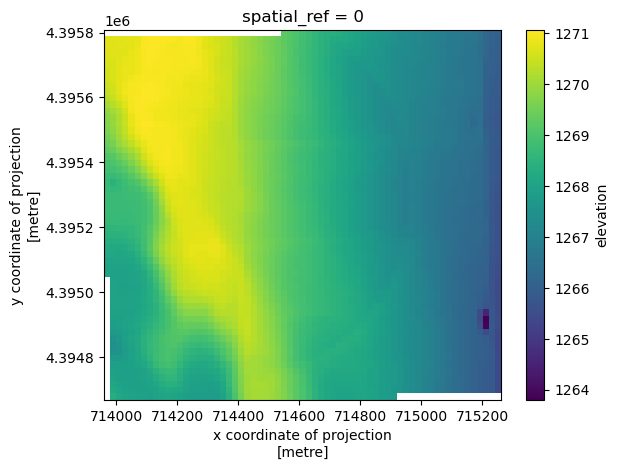

In [28]:
da_usgs_dem.coarsen(x=20, y=20, boundary='trim').mean().plot.imshow();

Download time (note that I'm working on removing the left_join column)

In [29]:
gf_neon

,id,title,start_datetime_left,end_datetime_left,product_url,geometry,workunit_left,workunit_id_left,project_left,project_id_left,...,onemeter_reason_right,seamless_category_right,seamless_reason_right,lpc_link_right,sourcedem_link_right,metadata_link_right,collection_right,datetime_right,dayofyear_right,duration_right
0,ARIK,Arikaree River NEON,2020-06,2020-06,https://data.neonscience.org/api/v0/data/DP3.3...,"POLYGON ((-102.60902 39.69825, -102.60871 39.7...",CO_CentralEasternPlains_1_2020,192973,CO_CentralEasternPlains_2020_D20,192976,...,Meets 3DEP 1-m DEM requirements,Meets,Meets 3DEP seamless DEM requirements,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,3DEP,2020-05-25,146,32


In [20]:
local_output_dir = "/home/jehayes/coincident/local_data" # in our .gitignore
# NOTE: NEON needs it's end_datetime, not start_datetime (separated by 1 month) to work, will fix the hardcoded arg
coincident.io.download.download_neon_dem(aoi=aoi,
                                        datetime_str="2020-06-01",
                                        site_id=gf_neon.id.item(),
                                        product="dsm",
                                        output_dir=local_output_dir)

In [21]:
coincident.io.download.download_neon_dem(aoi=aoi,
                                        datetime_str="2020-06-01",
                                        site_id=gf_neon.id.item(),
                                        product="lpc",
                                        output_dir=local_output_dir)

In [ ]:
coincident.io.download.download_usgs_dem(aoi=aoi,
                                        project=usgs_project,
                                        output_dir=local_output_dir,
                                        save_parquet=True # save a STAC-like geoparquet of the tiles you download
                                        )

In [ ]:
# TODO: fix loading bar, more than one tile for USGS above

Now let's look at how to load in and download NCALM and NOAA data, whose metadat structure is a bit messier than USGS 3DEP and NEOM LIDAR products

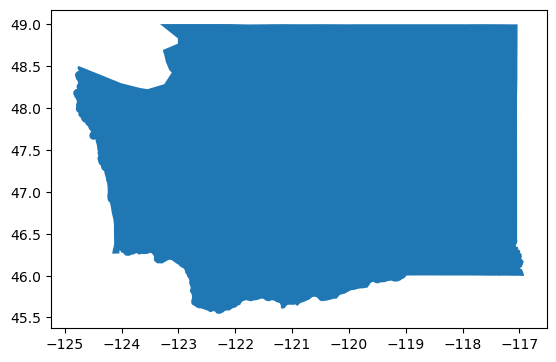

In [30]:
aoi = gpd.read_file(
    "https://raw.githubusercontent.com/unitedstates/districts/refs/heads/gh-pages/states/WA/shape.geojson"
)
aoi.plot();

In [31]:
gf_ncalm = coincident.search.search(dataset="ncalm", intersects=aoi, datetime=["2018-09-19"])

In [32]:
gf_ncalm

,id,name,title,start_datetime,end_datetime,geometry
0,OTLAS.072019.6339.1,WA18_Wall,"High-Resolution Mapping of Goat Rock Volcano, WA",2018-09-19,2018-09-20,"POLYGON ((-121.46701 46.48376, -121.45914 46.4..."


Now, let's subset to a small AOI for convenience sake

In [33]:
buffer_size = 0.01
centroid = gf_ncalm.centroid
mini_aoi = gpd.GeoDataFrame(
    geometry=[box(centroid.x-buffer_size, centroid.y-buffer_size, 
                 centroid.x+buffer_size, centroid.y+buffer_size)],
    crs="EPSG:4326"
)

/tmp/ipykernel_143769/1062712956.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gf_ncalm.centroid
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


In [34]:
m = gf_ncalm.explore()
mini_aoi.explore(m=m, color='red')

> [!NOTE]  
> The NCALM and user submitted opentopo DEMs are very strange in terms of metadata and tiling. For this site specifically, there are no tiles, just the entire site. this makes it so we have to load the entire dataset into memory

Also, they have strange naming conventions. Below are the s3 urls for this site. I'm not sure what GEG vs GEF is. I loaded them in and plotted them. They're overlapping and have nearly-identical elevation values (mms of difference). Because of this, the function by default returns the first file with a .tif extension it sees in the respective bucket

dem_urls = [
    "https://opentopography.s3.sdsc.edu/raster/WA18_Wall/WA18_Wall_be/WALL_GEG_1M.tif",
    "https://opentopography.s3.sdsc.edu/raster/WA18_Wall/WA18_Wall_hh/WALL_GEF_1M.tif"
]

In [35]:
%%time
ds_ncalm_dem = coincident.io.xarray.load_ncalm_dem(aoi=mini_aoi, dataset_id=gf_ncalm['name'].item())

CPU times: user 9.06 s, sys: 3.4 s, total: 12.5 s
Wall time: 21.6 s


In [36]:
ds_ncalm_dem

<xarray.Dataset> Size: 14MB
Dimensions:      (x: 1579, y: 2254)
Coordinates:
  * x            (x) float64 13kB 6.226e+05 6.226e+05 ... 6.242e+05 6.242e+05
  * y            (y) float64 18kB 5.152e+06 5.152e+06 ... 5.15e+06 5.15e+06
    spatial_ref  int64 8B 0
Data variables:
    elevation    (y, x) float32 14MB nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

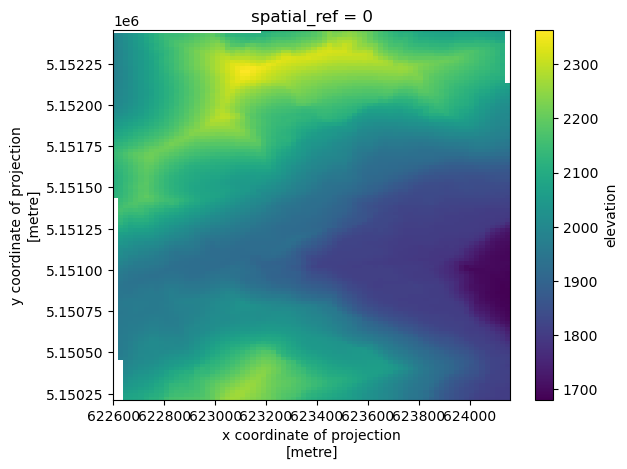

In [37]:
ds_ncalm_dem.elevation.coarsen(x=20, y=20, boundary='trim').mean().plot.imshow();

In [43]:
%%time
coincident.io.download.download_ncalm_dem(aoi=mini_aoi,
                                        dataset_id=gf_ncalm['name'].item(),
                                        output_dir=local_output_dir)

CPU times: user 17.4 s, sys: 5.72 s, total: 23.1 s
Wall time: 43.1 s


In [44]:
aoi = gpd.read_file(
    "https://raw.githubusercontent.com/unitedstates/districts/refs/heads/gh-pages/states/FL/shape.geojson"
)
gf_noaa = coincident.search.search(dataset="noaa", intersects=aoi, datetime=["2022-10-27"])

In [ ]:
#TODO: make nonaa aoi smaller, current is 7 tiles

In [45]:
buffer_size = 0.05
centroid = gf_noaa.centroid
mini_aoi = gpd.GeoDataFrame(
    geometry=[box(centroid.x-buffer_size, centroid.y-buffer_size, 
                 centroid.x+buffer_size, centroid.y+buffer_size)],
    crs="EPSG:4326"
)

/tmp/ipykernel_143769/1324535308.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gf_noaa.centroid
/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


In [46]:
m = gf_noaa.explore()
mini_aoi.explore(m=m, color='red')

the name and id being identical is expected

In [47]:
gf_noaa

,id,name,title,start_datetime,end_datetime,geometry
0,10149,10149,"2022 NOAA NGS Topobathy Lidar: Big Bend WMA, FL",2022-10-27,2022-11-29,"POLYGON ((-83.4654 29.36713, -83.35291 29.4196..."


> [!NOTE]  
> Our coincident.search.search(dataset="noaa") returns the dataset ids "Lidar Datasets at NOAA Digital Coast" whereas coincident.io.xarray.load_noaa_dem() requires the ids from the "Imagery and Elevation Raster Datasets at NOAA Digital Coast" dataset. The corresponding elevation raster dataset id is the same as the lidar dataset id + 1. e.g. "Great Bay NERR UAS Lidar" has id 10175 for lidar data and id 10176 for dem data

In [48]:
noaa_dem_id = int(gf_noaa.id.item())+1
print(f"NOAA LiDAR id: {gf_noaa.id.item()}  NOAA DEM id: {noaa_dem_id}")

NOAA LiDAR id: 10149  NOAA DEM id: 10150


```{warning}
The larger the NOAA flight, the longer the below function takes regardless of your input AOI
```

In [51]:
%%time
da_noaa_dem = coincident.io.xarray.load_noaa_dem(mini_aoi,noaa_dem_id)

CPU times: user 7.03 s, sys: 1.96 s, total: 8.99 s
Wall time: 20.7 s


In [52]:
da_noaa_dem

<xarray.DataArray 'elevation' (y: 11326, x: 9942)> Size: 450MB
dask.array<getitem, shape=(11326, 9942), dtype=float32, chunksize=(5000, 5000), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 80kB 2.207e+05 2.207e+05 ... 2.306e+05 2.306e+05
  * y            (y) float64 91kB 3.296e+06 3.296e+06 ... 3.307e+06 3.307e+06
    spatial_ref  int64 8B 0

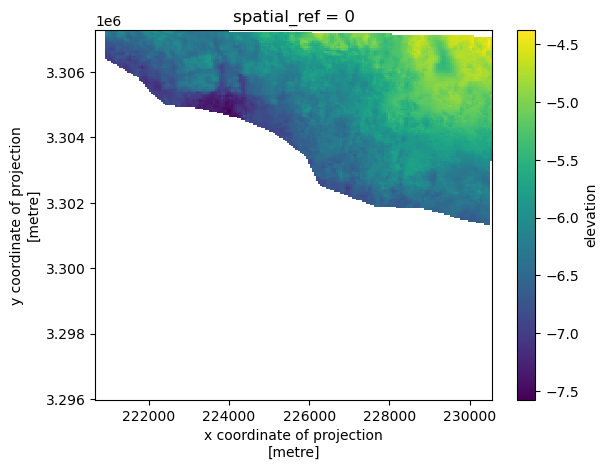

In [53]:
da_noaa_dem.coarsen(x=50, y=50, boundary='trim').mean().plot.imshow();

In [54]:
%%time
coincident.io.download.download_noaa_dem(aoi=mini_aoi,
                                        dataset_id=noaa_dem_id,
                                        output_dir=local_output_dir)

CPU times: user 11.8 s, sys: 3.87 s, total: 15.7 s
Wall time: 2min 5s
